In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as dt
import os
from os import path
import h5py
import re
from datetime import datetime
import requests
import calendar
import netCDF4 as nc
import json
import csv

In [2]:
'''
Initialize variables
'''

#It can be left blank if the txt file is in the same path as the script
UNR_SITE_LIST_FILE = ''
folder_name = '/Users/jonathanquartin/Documents/Coding/GitHub/um_volcano_project/GALAPAGOS_DATA'

lat = round(-.25)
lon = round(-91.35)

#Format yyyy-dd-MM
start_date = '2000-01-06'
end_date = '2021-30-09'

In [3]:
def date_to_decimal_year(date_str):
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    year = date_obj.year
    day_of_year = date_obj.timetuple().tm_yday
    decimal_year = year + (day_of_year - 1) / 365.0
    decimal_year = round(decimal_year,4) 
    return decimal_year

In [4]:
def days_in_month(date):
    year, month, day = map(int, date.split("-"))
    num_days = calendar.monthrange(year, month)[1]
    return num_days

In [5]:
def generate_coordinate_array():
    lon = []
    lat=[]
    lo=-179.95
    la=-89.95

    for i in range(0,3600):
        lon.append(round(lo,2))
        lo+=0.1

    for i in range(0,1800):
        lat.append(round(la,2))
        la+=0.1
        
    return(lon,lat)

In [6]:
def extract_volcanoes_info(json):
    f = open(json)
    data = json.load(f)
    for j in data['features']:
        print(j['properties']['VolcanoName'])
        print(j['properties']['StartDate'])
        print(j['properties']['EndDate'])

In [7]:
def adapt_coordinates(lon, lat):

    if -179.95 <= lon <= 179.95:

        val = 0.05 if lon > 0 else  -0.05
        lon = lon + val
        
    else:
        raise ValueError(f'Values not in the Interval (-179.5, 179.5)')
        
    if -89.95 <= lat <= 89.95:

        val = 0.05 if lat > 0 else -0.05
        lat = lat + val

    else:
        raise ValueError(f'Values not in the Interval (-89.95, 89.95)')
        
    return lon, lat

In [8]:
def dload_site_list_hdf5(folder, path):
    '''
    Creates data folder
    '''
    if not folder:
        folder = 'data'
    
    if not os.path.exists(folder):
        os.mkdir(folder)

    '''
    Looks for list of links i.e. the only txt file in the current folder
    '''
    if not path:
    
        txt_files = [f for f in os.listdir('.') if f.endswith('.txt') and f.startswith('subset')]
        #JQ - added startswith

        if len(txt_files) != 1:
            raise ValueError('should be only one txt file in the current directory')

        path = txt_files[0]
        print(path)

    '''
    Loop torough every line in the list of links .txt file and download every .HDF5 file within the list
    '''

    with open(path, "r") as ifile:
            for URL in ifile:
                if '.nc4' in URL[-6:]:

                    d = re.search('\d{8}', URL)
                    d.group(0)
                    date = datetime.strptime(d.group(0), "%Y%m%d").date()

                    FILENAME = folder + '/'+ str(date) + '.nc4'

                    if not os.path.exists(FILENAME):

                        result = requests.get(URL.strip())

                        try:
                            result.raise_for_status()
                            f = open(FILENAME,'wb')
                            f.write(result.content)
                            f.close()
                            print('contents of URL written to '+FILENAME)
                        except:
                            print('requests.get() returned an error code '+str(result.status_code))

                    else:
                        print(f'File: {FILENAME} already exists')
    return folder

In [10]:
def plot_precipitaion_hdf5(longitude, latitude, start_date, end_date, folder, path):
        
        finaldf = {}
        df = pd.DataFrame()
        dictionary = {}
        
        lon,lat = generate_coordinate_array()
    
        longitude, latitude = adapt_coordinates(longitude, latitude)

        sdate = datetime.strptime(start_date,'%Y-%d-%m')
        edate = datetime.strptime(end_date,'%Y-%d-%m')
        
        #Create a date range with the input dates, from start_date to end_date
        date_list = pd.date_range(start = sdate,end = edate).date
        
        #If the folder name is left blank, it will be automatically named 'data'
        if not folder:
            folder = 'data'

        '''
        Check if files date is in range with the input dates
        '''   
        
        #Check if folder exists, otherwise execute download function
        if not os.path.exists(folder):
            folder = dload_site_list_hdf5(folder, path)
            
        else:
            
            try:
                
                #Converts file names within the data folder in date
                sd = datetime.strptime(os.listdir(folder)[0].replace('.HDF5',''),'%Y-%d-%m').date()
                ed = datetime.strptime(os.listdir(folder)[-1].replace('.HDF5',''),'%Y-%d-%m').date()

                #Create a range of dates with the name of the files within the data folder
                file_date_list = pd.date_range(start = sd,end = ed).date

                #Check if the date range passed as input is within the date range created from the downloaded files
                #if not, launch the download function
                if not all(elem in file_date_list for elem in date_list):

                    folder = dload_site_list_hdf5(folder, path)
            except:
                
                folder = dload_site_list_hdf5(folder, path)

        '''
        Loops trough every HDF5 file
        '''
        
        #For each file in the data folder that as HDF5 extension
        for f in os.listdir(folder):

            if f.endswith('.HDF5'):

                file = './' + folder + '/'+ f
                    
                data = h5py.File(file,'r')

                d = re.search('\d{4}[-]\d{2}[-]\d{2}', file)
                date = datetime.strptime(d.group(0), "%Y-%d-%m").date()

                if date in date_list:

                    dictionary[str(date)] = {}

                    for key in data.keys():        
                        pre = data[key]['precipitation']
                        lonPrec = dict(zip(lon, zip(*pre)))

                    lonPrec[longitude]

                    i = list(lat).index(latitude)
                    dictionary[str(date)] = lonPrec[longitude][0][i]

                    df1 = pd.DataFrame(dictionary.items(), columns=['Date', 'Precipitation'])
                    finaldf = pd.concat([df,df1], ignore_index=True, sort=False)

                else: continue
                    
        return finaldf  

In [11]:
def plot_precipitaion_nc4(longitude, latitude, start_date, end_date, folder, path):
        
        finaldf = {}
        df = pd.DataFrame()
        dictionary = {}
    
        longitude, latitude = adapt_coordinates(longitude, latitude)

        sdate = datetime.strptime(start_date,'%Y-%d-%m')
        edate = datetime.strptime(end_date,'%Y-%d-%m')
        
        #Create a date range with the input dates, from start_date to end_date
        date_list = pd.date_range(start = sdate,end = edate).date
        
        #If the folder name is left blank, it will be automatically named 'data'
        if not folder:
            folder = 'data'

        '''
        Check if files date is in range with the input dates
        '''   
        
        #Check if folder exists, otherwise execute download function
        if not os.path.exists(folder):
            folder = dload_site_list_hdf5(folder, path)
            
        else:
            
            try:
                
                #Converts file names within the data folder in date
                sd = datetime.strptime(os.listdir(folder)[0].replace('.nc4',''),'%Y-%d-%m').date()
                ed = datetime.strptime(os.listdir(folder)[-1].replace('.nc4',''),'%Y-%d-%m').date()

                #Create a range of dates with the name of the files within the data folder
                file_date_list = pd.date_range(start = sd,end = ed).date

                #Check if the date range passed as input is within the date range created from the downloaded files
                #if not, launch the download function
                if not all(elem in file_date_list for elem in date_list):

                    folder = dload_site_list_hdf5(folder, path)
            except:
                
                folder = dload_site_list_hdf5(folder, path)
                
        '''
        Create longitude and latitude arrays
        '''               
                
        lon,lat = generate_coordinate_array()

        #JQ -- this should be changed to whatever coordinates we are working with, correct?    
        lon_index = lon.index(longitude)
        lat_index = lat.index(latitude)

        '''
        Loops trough every nc4 file
        '''
        
        #For each file in the data folder that as nc4 extension
        for f in os.listdir(folder):

            if f.endswith('.nc4'):

                #Open the file
                file = './' + folder + '/'+ f
                ds = nc.Dataset(file)
                
                #Extract date from file name
                d = re.search('\d{4}[-]\d{2}[-]\d{2}', file)
                date = datetime.strptime(d.group(0), "%Y-%m-%d").date()

                if date in date_list:

                    dictionary[str(date)] = {}

                    data = ds['precipitationCal']
                    data[0,lon_index,lat_index]

                    dictionary[str(date)] = float(data[0,lon_index,lat_index])
                    #Sorted the dictionary -- JQ
                    df1 = pd.DataFrame(sorted(dictionary.items()), columns=['Date', 'Precipitation'])
                    finaldf = pd.concat([df,df1], ignore_index=True, sort=False)

                else: continue
                    
        return finaldf  

In [15]:
#If dataset has .nc4 extension
newdf = plot_precipitaion_nc4(lon, lat, start_date, end_date, folder_name, '') 

subset_GPM_3IMERGDF_06_20230917_160246_.txt
File: data/2000-06-01.nc4 already exists
File: data/2000-06-02.nc4 already exists
File: data/2000-06-03.nc4 already exists
File: data/2000-06-04.nc4 already exists
File: data/2000-06-05.nc4 already exists
File: data/2000-06-06.nc4 already exists
File: data/2000-06-07.nc4 already exists
File: data/2000-06-08.nc4 already exists
File: data/2000-06-09.nc4 already exists
File: data/2000-06-10.nc4 already exists
File: data/2000-06-11.nc4 already exists
File: data/2000-06-12.nc4 already exists
File: data/2000-06-13.nc4 already exists
File: data/2000-06-14.nc4 already exists
File: data/2000-06-15.nc4 already exists
File: data/2000-06-16.nc4 already exists
File: data/2000-06-17.nc4 already exists
File: data/2000-06-18.nc4 already exists
File: data/2000-06-19.nc4 already exists
File: data/2000-06-20.nc4 already exists
File: data/2000-06-21.nc4 already exists
File: data/2000-06-22.nc4 already exists
File: data/2000-06-23.nc4 already exists
File: data/20

In [19]:
newdf.to_csv('fernandina_one.csv',index=False)
print(max(newdf['Precipitation']))

109.56098937988281


In [12]:
#JQ uses below so that indices are preset to make a bounding box
def index_box(west, east, south, north):
    width = int(round((east - west) * 10, 0))
    height = int(round((north - south) * 10,0))
    lon, lat = generate_coordinate_array()
    first = [lon.index(west), lat.index(south)]
    box = np.array([[first[0] + i, first[1] + j] for i in range(width) for j in range(height)])
    return box

In [16]:
csv_file_name = 'precipitation_galapagos.csv'
#Fix this so that it doesnt overwrite the header

column_names = ['Date', 'Longitude', 'Latitude', 'Precipitation']

# Open the CSV file in write mode ('w', 'wb', or 'w+', depending on your Python version).
with open(csv_file_name, mode='w', newline='') as csv_file:
    # Create a DictWriter object with the column names.
    csv_writer = csv.DictWriter(csv_file, fieldnames=column_names)

    # Write the header (column names) to the CSV file.
    csv_writer.writeheader()

In [14]:
#JQ version that gathers data points from around the chosen location
west = -92.45
east = -87.05
south = -2.15
north = 2.15
indices = index_box(west, east, south, north)
lon, lat = generate_coordinate_array()
rows = []
sdate = datetime.strptime(start_date,'%Y-%d-%m')
edate = datetime.strptime(end_date,'%Y-%d-%m')
        
#Create a date range with the input dates, from start_date to end_date
date_list = pd.date_range(start = sdate,end = edate).date



for f in os.listdir('data'):

    if f.startswith('201') or f.startswith('202'):
        
        with open('precipitation_galapagos.csv', mode='a', newline='') as main:
            csv_writer = csv.writer(main)
            #Open the file
            file = './' + folder_name + '/'+ f
            ds = nc.Dataset(file)
                
            #Extract date from file name
            d = re.search('\d{4}[-]\d{2}[-]\d{2}', file)
            date = datetime.strptime(d.group(0), "%Y-%m-%d").date()

            data = ds['precipitationCal']
            for i in indices:
                csv_writer.writerow([date, lon[i[0]], lat[i[1]], data[0,i[0],i[1]]])


In [23]:
rainfall = pd.read_csv("precipitation_galapagos.csv")
print(max(rainfall['Date']))

2001-09-30


/var/folders/d0/48hh0ndj2v59mjry93b9grn00000gn/T/ipykernel_13139/3538773581.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rainfalldfNoNull['Decimal_Year'] = rainfalldfNoNull['Date'].apply(date_to_decimal_year)


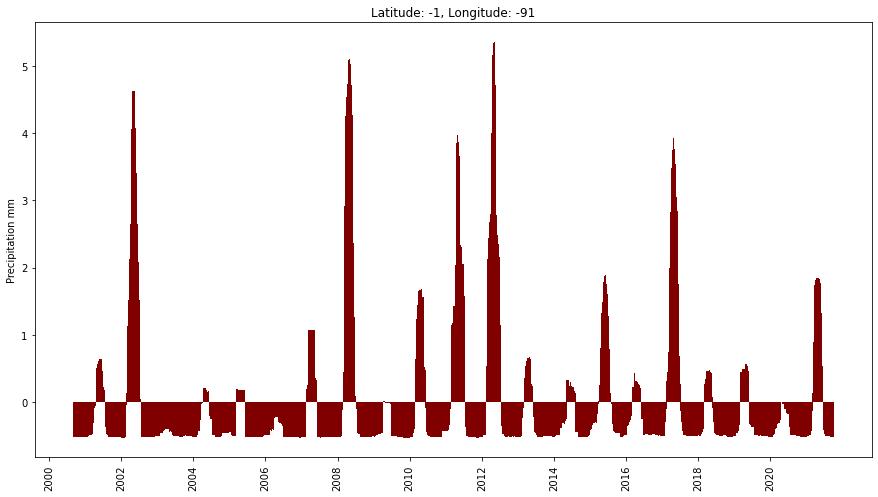

,Date,Precipitation,roll90,Decimal_Year
89,2000-08-29,0.000000,0.014139,2000.6603
90,2000-08-30,0.000000,0.003465,2000.6630
91,2000-08-31,0.000000,0.003465,2000.6658
92,2000-09-01,0.000000,0.003465,2000.6685
93,2000-09-02,0.000000,0.003465,2000.6712
...,...,...,...,...
7787,2021-09-26,0.000000,0.009282,2021.7342
7788,2021-09-27,0.005636,0.009288,2021.7370
7789,2021-09-28,0.000343,0.008779,2021.7397
7790,2021-09-29,0.000000,0.008464,2021.7425


In [22]:
#JQ additions
true_mean = newdf.Precipitation.mean()
newdf["roll90"] = newdf.Precipitation.rolling(90).mean()

rainfalldfNoNull =newdf.dropna()

Precipitation=np.array(rainfalldfNoNull['roll90'] - true_mean)

# Convert date strings to decimal years
rainfalldfNoNull['Decimal_Year'] = rainfalldfNoNull['Date'].apply(date_to_decimal_year)

plt.figure(figsize=(15,8))

# x = rainfalldfNoNull.Decimal_Year
# y = rainfalldfNoNull.Precipitation

plt.bar(rainfalldfNoNull.Decimal_Year, Precipitation, color ='maroon',
       width = 0.01)

plt.ylabel("Precipitation mm")
 
plt.title(f'Latitude: {lat}, Longitude: {lon}')

plt.xticks(ticks=[2000 + 2*i for i in range(11)], rotation=90)

# Data plot
plt.show()
rainfalldfNoNull



In [118]:
#If dataset has .hdf5 extension
# newdf = plot_precipitaion_hdf5(lon, lat, start_date, end_date, folder_name, '') 

[89     2014-08-29
90     2014-08-30
91     2014-08-31
92     2014-09-01
93     2014-09-02
          ...    
727    2016-05-28
728    2016-05-29
729    2016-05-30
730    2016-05-31
731    2016-06-01
Name: Date, Length: 643, dtype: object]
1
a
{}


/var/folders/d0/48hh0ndj2v59mjry93b9grn00000gn/T/ipykernel_11043/3380929787.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rainfalldfNoNull['Decimal_Year'] = rainfalldfNoNull['Date'].apply(date_to_decimal_year)
/var/folders/d0/48hh0ndj2v59mjry93b9grn00000gn/T/ipykernel_11043/3380929787.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rainfalldfNoNull["cum"] = rainfalldfNoNull.Precipitation.cumsum()


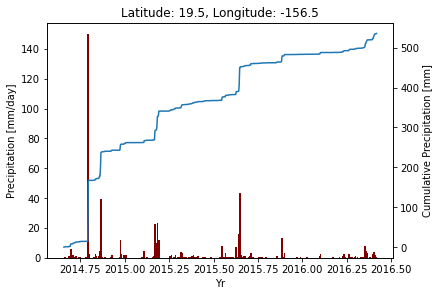

,Date,Precipitation,roll90,Decimal_Year,cum
89,2014-08-29,0.102591,12.914582,2014.6575,0.102591
90,2014-08-30,0.529980,13.444562,2014.6603,0.632571
91,2014-08-31,0.000000,13.419422,2014.6630,0.632571
92,2014-09-01,0.405519,13.824941,2014.6658,1.038090
93,2014-09-02,0.000000,13.824941,2014.6685,1.038090
...,...,...,...,...,...
727,2016-05-28,1.778602,44.759391,2016.4055,532.694800
728,2016-05-29,2.165114,46.924504,2016.4082,534.859913
729,2016-05-30,0.000023,46.924527,2016.4110,534.859936
730,2016-05-31,0.010238,46.934765,2016.4137,534.870174


In [50]:
# newdf["roll7"] = newdf.Precipitation.rolling(7).sum()
# newdf["roll90"] = newdf.Precipitation.rolling(90).sum()
# newdf["roll180"] = newdf.Precipitation.rolling(180).sum()

# newdf["log30"] = np.log(newdf.roll30)
# newdf["log90"] = np.log(newdf.roll90)
# newdf["log180"] = np.log(newdf.roll180)
# newdf['norm']=(newdf.Precipitation-newdf.Precipitation.min())/(newdf.Precipitation.max()-newdf.Precipitation.min())

rainfalldfNoNull =newdf.dropna()

# rainfalldfNoNull['DateTime'] = pd.to_datetime(rainfalldfNoNull['Date'], format='%Y-%m-%d')
# rainfalldfNoNull['Decimal_Year'] = rainfalldfNoNull['Date'].apply(date_to_decimal_year)

# plt.plot(rainfalldfNoNull.DateTime, rainfalldfNoNull.Precipitation)
# plt.gca().xaxis.set_major_locator(dt.DayLocator(interval=50))
# plt.xticks(rotation=90)

# plt.show

weekly_dict = {}
Precipitation=[]

if 'Precipitation' in rainfalldfNoNull:
    # Iterate through the dictionary and extract the values for the specified field
    for key, value in rainfalldfNoNull.items():
        if key == 'Precipitation':
            Precipitation.append(value)
        
Dates = []
if 'Date' in rainfalldfNoNull:
    # Iterate through the dictionary and extract the values for the specified field
    for key, value in rainfalldfNoNull.items():
        if key == 'Date':
            Dates.append(value)

print(Dates)
print(len(Precipitation))
            
for i in range (0,len(Dates)):
    print('a')
            
    # Convert the date string to a datetime object
#     try:
#         date = datetime.strptime(date_str, '%Y-%m-%d')
#     except ValueError:
#         # Skip entries with incorrect date strings
#         print(f"Skipping entry with incorrect date string: {date_str}")
#         continue
    
    # Calculate the week number for the current date
#     week_number = date.isocalendar()[1]  # Get the ISO week number
#     print(week_number)
    
#     # If the week number is not in the weekly dictionary, add it with the current value
#     if week_number not in weekly_dict:
#         weekly_dict[week_number] = value
#     else:
#         # If the week number is already in the weekly dictionary, add the current value to it
#         weekly_dict[week_number] += value

    

# Print the weekly dictionary
print(weekly_dict)




# Convert date strings to decimal years
rainfalldfNoNull['Decimal_Year'] = rainfalldfNoNull['Date'].apply(date_to_decimal_year)


rainfalldfNoNull["cum"] = rainfalldfNoNull.Precipitation.cumsum()

fig, ax = plt.subplots(layout='constrained')

# x = rainfalldfNoNull.Decimal_Year
# y = rainfalldfNoNull.Precipitation

plt.bar(rainfalldfNoNull.Decimal_Year, rainfalldfNoNull.Precipitation, color ='maroon',
        width = 0.01)

plt.ylabel("Precipitation [mm/day]")

rainfalldfNoNull.plot('Decimal_Year', 'cum', secondary_y=True, ax=ax)
 
plt.title(f'Latitude: {lat}, Longitude: {lon}')
ax.set_xlabel("Yr")
ax.right_ax.set_ylabel("Cumulative Precipitation [mm]")

ax.get_legend().remove()

plt.xticks(rotation=90)

# Data plot
plt.show()
rainfalldfNoNull

In [48]:
'''
Example of global precipitations given by Nasa at: https://gpm.nasa.gov/data/tutorials
'''

data = h5py.File(file,'r')
precip = data['/Grid/precipitation'][:]
precip = np.flip( precip[0,:,:].transpose(), axis=0 )
plt.imshow( precip, vmin=-1, vmax=2, extent=[-180,180,-90,90] )

# -- add a color bar
cbar = plt.colorbar( )
cbar.set_label('millimeters/hour')

# -- display lat/lon grid lines
for lon in np.arange(-90,90+1,90):
  dummy = plt.plot( (lon,lon), (-90,+90), color="black", linewidth=1 )

for lat in np.arange(-60,60+1,30):
  dummy = plt.plot( (-180,+180), (lat,lat), color="black", linewidth=1 )

NameError: name 'file' is not defined